<a href="https://colab.research.google.com/github/hoiyurie/tibame-ml0602/blob/main/transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
fn = "/content/drive/MyDrive/train.zip"
zf = zipfile.ZipFile(fn)
zf.extractall() # 解壓縮到colab配置的機器裡，不要解壓縮到自己的drive裡

# 多出來的train的資料夾就是image data


25000
(499, 333)


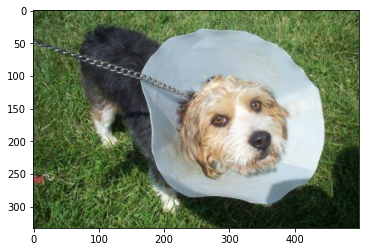

In [2]:
# glob：同一層的train檔案
import glob
import matplotlib.pyplot as plt
from PIL import Image

fns = glob.glob("train/*")# glob：同一層的train檔案
print(len(fns))
img = Image.open(fns[0])
print(img.size) # 每張圖片size不同，因此進model（imagenet）之前要resize成224x224
plt.imshow(img)

In [3]:
# ！不要直接先讀圖，會爆炸

# 把需要的整理成dataframe

import pandas as pd
dogf = glob.glob("train/dog.*") # 把dog的img全部抓出來
catf = glob.glob("train/cat.*") # 把cat的img全部抓出來

data = pd.DataFrame({
    "path":dogf + catf, # list
    "target":[0]*len(dogf) +[1]*len(catf)
})

# [0] :dog ; [1]:cat ，把所有狗變成0，貓變成1

data

,path,target
0,train/dog.10694.jpg,0
1,train/dog.4214.jpg,0
2,train/dog.1140.jpg,0
3,train/dog.7814.jpg,0
4,train/dog.456.jpg,0
...,...,...
24995,train/cat.7656.jpg,1
24996,train/cat.2840.jpg,1
24997,train/cat.9132.jpg,1
24998,train/cat.5773.jpg,1


In [4]:
# 如果一些函式庫想要使用 tensorflow_version 1,可以使用以下指令：
# % tensorflow_version 1.x

# 通常默認情況是：tensorflow_version 2 


# 方法1:model的使用方式
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense

vgg = VGG16(include_top=False, input_shape=(224,224,3))
t1 = GlobalAveragePooling2D()(vgg.output)
out = Dense(2, activation = "softmax")(t1)
model= Model(inputs=vgg.input , outputs=out)
model.summary


58892288/58889256 [==============================] - 0s 0us/step


<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7fe5606ce350>>

In [5]:
# 方法2: Sequential
from tensorflow.keras.layers import BatchNormalization
vgg = VGG16(include_top=False, input_shape=(224,224,3))

# trainable 設定一定要再compile之前
for l in vgg.layers:
  l.trainable = False  # 這一層的layer全部不訓練，只有自己的1026(512*2+2)是trainable


layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model = Sequential(vgg.layers + layers)
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [6]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

In [7]:
# 隨便抽出來一張

import numpy as np


# 圖片預處理：不是除 255.0 ，請always 使用你偷來的模型同樣預處理方式

# google : preprocess_input github
# https://www.google.com/search?q=preprocess_input+github&oq=prepr&aqs=chrome.1.69i57j35i39j0i433j0l3j69i60j69i61.2529j0j4&sourceid=chrome&ie=UTF-8


from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(fns[0]).convert("RGB").resize((224, 224))
img_np = np.array(img)
preprocess_input(img_np)

array([[[ -38.939003 ,   -2.7789993,  -31.68     ],
        [ -71.939    ,  -35.779    ,  -64.68     ],
        [ -49.939003 ,  -15.778999 ,  -44.68     ],
        ...,
        [ -18.939003 ,   10.221001 ,  -16.68     ],
        [ -51.939003 ,  -22.779    ,  -49.68     ],
        [ -53.939003 ,  -20.779    ,  -53.68     ]],

       [[ -67.939    ,  -31.779    ,  -60.68     ],
        [ -75.939    ,  -40.779    ,  -69.68     ],
        [ -53.939003 ,  -19.779    ,  -48.68     ],
        ...,
        [ -41.939003 ,   -9.778999 ,  -37.68     ],
        [ -50.939003 ,  -18.779    ,  -46.68     ],
        [ -42.939003 ,   -8.778999 ,  -41.68     ]],

       [[ -69.939    ,  -33.779    ,  -62.68     ],
        [ -64.939    ,  -29.779    ,  -58.68     ],
        [ -28.939003 ,    5.2210007,  -23.68     ],
        ...,
        [ -58.939003 ,  -21.779    ,  -50.68     ],
        [ -37.939003 ,   -3.7789993,  -32.68     ],
        [ -14.939003 ,   20.221    ,  -12.68     ]],

       ...,

      

In [8]:

# 我們無法使用fit, 1. fit_generator 2.train_on_batch/test_on_batch
# random.randint(0, 2(inclusive)): 0,1,2
# np.random,randint(0, 3(exclusive)): 0,1,2
def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), size=batch)
    # print(idx)
    xidx, yidx = x[idx], y[idx]
    img_ori, img_pre, ans = [], [], []
    for xi, yi in zip(xidx, yidx):
        img = Image.open(xi).convert("RGB").resize((224, 224))
        img_np = np.array(img)
        img_p = preprocess_input(img_np)
        img_ori.append(img_np)
        img_pre.append(img_p)
        ans.append(yi)
    return np.array(img_ori), np.array(img_pre), np.array(ans)

In [9]:

from sklearn.model_selection import train_test_split
x, y = np.array(data["path"]), np.array(data["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
img_ori, img_pre, ans = get_data(x_train, y_train)
print(img_ori.shape) # (20, 224, 224, 3) : 20張，224 x 224 長寬，RGB 
print(img_pre.shape) # (20, 224, 224, 3)
print(ans.shape) # (20,)

(20, 224, 224, 3)
(20, 224, 224, 3)
(20,)


In [10]:
for i in range(100):
    print("-" * 15, i, "-" * 15)
    img_ori, img_p, ans = get_data(x_train, y_train)
    result = model.train_on_batch(img_p, ans)
    print("train:", result)  # loss ， accurancy
    img_ori, img_p, ans = get_data(x_test, y_test)
    result = model.test_on_batch(img_p, ans)
    print("validate:", result)

--------------- 0 ---------------
train: [0.606528639793396, 0.6499999761581421]
validate: [1.1411234140396118, 0.5]
--------------- 1 ---------------
train: [0.6515731811523438, 0.550000011920929]
validate: [0.9720019102096558, 0.6499999761581421]
--------------- 2 ---------------
train: [0.6840226054191589, 0.6000000238418579]
validate: [0.63762366771698, 0.75]
--------------- 3 ---------------
train: [0.7223172187805176, 0.44999998807907104]
validate: [0.290562242269516, 0.8500000238418579]
--------------- 4 ---------------
train: [0.7203906774520874, 0.550000011920929]
validate: [0.8098670840263367, 0.550000011920929]
--------------- 5 ---------------
train: [0.6351048350334167, 0.6499999761581421]
validate: [0.6286212801933289, 0.699999988079071]
--------------- 6 ---------------
train: [0.580187201499939, 0.699999988079071]
validate: [0.8898802995681763, 0.5]
--------------- 7 ---------------
train: [0.6809437274932861, 0.6000000238418579]
validate: [0.7186403870582581, 0.6000000

In [11]:

# 1. 發覺loss跳動幅度太高
# 2. 發覺預測機率1.0 * e+0
# 沒有把輸入調整到合理範圍(norm)
img_ori, img_p, ans = get_data(x_test, y_test, batch=200)
pre = model.predict(img_p)
# Model沒有predict_classes可以用, 以後好像也要移除predict_classes
classes = pre.argmax(axis=1)
model.evaluate(img_p, ans)

7/7 [==============================] - 1s 112ms/step - loss: 0.1458 - accuracy: 0.9750


[0.1458413004875183, 0.9750000238418579]

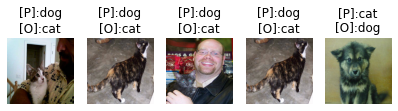

In [12]:

import numpy as np
names = ["dog", "cat"]
idx = np.nonzero(classes != ans)[0]
# np.nonzero([[0, 2, 0], [0, 0, 3]])
false_pre = classes[idx]
false_label = ans[idx] 
false_img = img_ori[idx]

plt.figure(figsize=(14, 42))
width = 10
height = len(idx) // width + 1
for i in range(len(false_img)):
    plt.subplot(height, width, i+1)
    title = "[P]:{}\n[O]:{}".format(names[false_pre[i]], names[false_label[i]])
    plt.title(title)
    plt.axis("off")
    plt.imshow(false_img[i])

輸入網址:https://images.chinatimes.com/newsphoto/2020-12-01/656/20201201006541.jpg


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


dog 的機率: 0.922
cat 的機率: 0.078


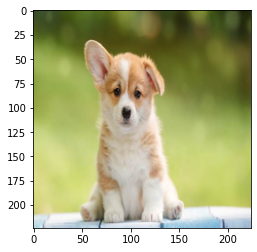

In [15]:
import requests
from PIL import Image
url = input("輸入網址:")
response = requests.get(url, verify=False, stream=True)
img = Image.open(response.raw)
img = img.resize((224, 224)).convert("RGB")
img_np = np.array(img).reshape(1, 224, 224, 3)
img_norm = preprocess_input(img_np)
pre = model.predict(img_norm)[0]
for n, p in zip(names, pre):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)